In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import string
import re
import os
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

In [37]:
def plot_conf_matrix(y_pred, y_true, title=None):
    """Helper Function to plot confustion matrix"""
    
    conf_mat = confusion_matrix(y_pred, y_true)
    df_cm = pd.DataFrame(conf_mat, index = [i for i in ["Fake", "Real"]],
                  columns = [i for i in ["Fake", "Real"]])
    plt.figure(figsize = (10,7))
    sns.heatmap(df_cm, annot=True, cmap="Blues")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    if title:
        plt.title(f"{title} Confusion Matrix")
    plt.show()

[CV 5/5; 1/90] START learning_rate=0.001, loss=deviance, n_estimators=10, subsample=0.5
[CV 5/5; 1/90] END learning_rate=0.001, loss=deviance, n_estimators=10, subsample=0.5;, score=0.507 total time=   0.3s
[CV 5/5; 3/90] START learning_rate=0.001, loss=deviance, n_estimators=10, subsample=1.0
[CV 5/5; 3/90] END learning_rate=0.001, loss=deviance, n_estimators=10, subsample=1.0;, score=0.507 total time=   0.6s
[CV 1/5; 6/90] START learning_rate=0.001, loss=deviance, n_estimators=50, subsample=1.0
[CV 1/5; 6/90] END learning_rate=0.001, loss=deviance, n_estimators=50, subsample=1.0;, score=0.986 total time=   3.0s
[CV 4/5; 8/90] START learning_rate=0.001, loss=deviance, n_estimators=100, subsample=0.75
[CV 4/5; 8/90] END learning_rate=0.001, loss=deviance, n_estimators=100, subsample=0.75;, score=0.970 total time=   5.4s
[CV 1/5; 14/90] START learning_rate=0.001, loss=exponential, n_estimators=50, subsample=0.75
[CV 1/5; 14/90] END learning_rate=0.001, loss=exponential, n_estimators=50,

# Read in Data and Preprocess

In [3]:
true_news_df = pd.read_csv("COVID19-FNIR/COVID19-FNIR/trueNews.csv")
fake_news_df = pd.read_csv("COVID19-FNIR/COVID19-FNIR/fakeNews.csv")

In [4]:
# Assign class columns and combine dataframes
fake_news_df["class"] = 0
true_news_df["class"] = 1
combined = pd.concat([fake_news_df, true_news_df], axis=0)

In [5]:
# Subset data to just contain the text field and the class field
combined = combined[["Text", "class"]].reset_index(drop=True)
# Shuffle data
combined = combined.sample(frac = 1)

In [6]:
combined.head()

,Text,class
3381,A migrant travelling home amidst the coronavi...,0
6078,Hospitals treating COVID-19 in Mexican capital...,1
2439,Teen spitting in tea bottle to spread the cor...,0
3737,The list shows the medicines issued by a doct...,0
1631,Italians threw away their currency on the str...,0


In [7]:
def wordopt(text):
    """Formating of the text field """
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub("\\W"," ",text) 
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)    
    return text

In [8]:
combined["Text"] = combined["Text"].apply(wordopt)

In [9]:
combined.head()

,Text,class
3381,a migrant travelling home amidst the coronavi...,0
6078,hospitals treating covid in mexican capital q...,1
2439,teen spitting in tea bottle to spread the cor...,0
3737,the list shows the medicines issued by a doct...,0
1631,italians threw away their currency on the str...,0


In [10]:
# Set X and y variables
X = combined["Text"]
y = combined["class"]

In [11]:
# Split data into training and test dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer

# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html 

vectorization = TfidfVectorizer()
X_train = vectorization.fit_transform(X_train)
X_test = vectorization.transform(X_test)

# Model 1: Naive Bayes Model

In [13]:
from sklearn.naive_bayes import MultinomialNB


nb_model = MultinomialNB()
# Fit model 
nb_model.fit(X_train, y_train)
# Predict 
y_pred = nb_model.predict(X_test)

In [14]:
print(f"Test Accuracy: {accuracy_score(y_test, y_pred)}")

Test Accuracy: 0.9620453347390617


In [15]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.94      0.96       991
           1       0.93      0.99      0.96       906

    accuracy                           0.96      1897
   macro avg       0.96      0.96      0.96      1897
weighted avg       0.96      0.96      0.96      1897



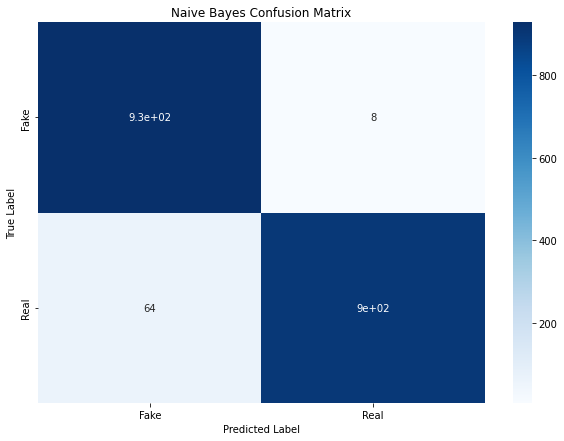

In [16]:
plot_conf_matrix(y_pred, y_test, title="Naive Bayes")

In [17]:
# 
params = {
    "alpha": [0.001, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.75, 1, 1.5, 2, 3, 5, 10],
    "fit_prior": (True, False),
}
gs_clf = GridSearchCV(MultinomialNB(), params, n_jobs=-1)
gs_clf = gs_clf.fit(X_train, y_train)

In [36]:
# gs_clf.cv_results_

In [19]:
y_pred = gs_clf.predict(X_test)

In [20]:
print(f"Test Accuracy: {accuracy_score(y_test, y_pred)}")

Test Accuracy: 0.9599367422245652


In [21]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.93      0.96       991
           1       0.93      0.99      0.96       906

    accuracy                           0.96      1897
   macro avg       0.96      0.96      0.96      1897
weighted avg       0.96      0.96      0.96      1897



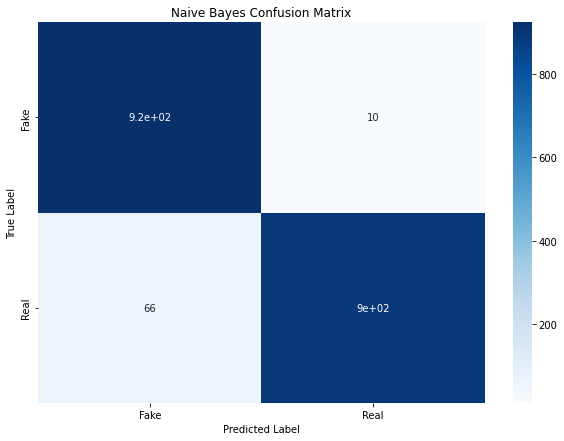

In [22]:
plot_conf_matrix(y_pred, y_test, title="Naive Bayes")

# Model 2: Gradient Boosting Classifier

In [23]:
from sklearn.ensemble import GradientBoostingClassifier

gbt_model = GradientBoostingClassifier()
# Fit model 
gbt_model.fit(X_train, y_train)
# Predict 
y_pred = gbt_model.predict(X_test)

In [24]:
print(f"Test Accuracy: {accuracy_score(y_test, y_pred)}")

Test Accuracy: 0.9957828149710068


In [25]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       991
           1       1.00      0.99      1.00       906

    accuracy                           1.00      1897
   macro avg       1.00      1.00      1.00      1897
weighted avg       1.00      1.00      1.00      1897



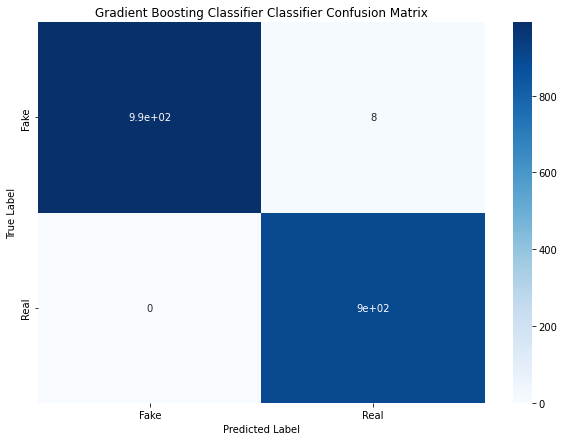

In [26]:
plot_conf_matrix(y_pred, y_test, title="Gradient Boosting Classifier Classifier")

In [27]:
%%time
params = {
    "loss": ["deviance", "exponential"],
    "learning_rate": [0.001, 0.01, 0.1, 1, 2],
    "n_estimators": [10, 50, 100],
    "subsample": [0.5, 0.75, 1.0],
}

gs_clf = GridSearchCV(GradientBoostingClassifier(), params, n_jobs=-1, scoring='accuracy', verbose=10)
  
gs_clf = gs_clf.fit(X_train, y_train)
# Predict 
y_pred = gs_clf.predict(X_test)

Fitting 5 folds for each of 90 candidates, totalling 450 fits
[CV 2/5; 3/90] START learning_rate=0.001, loss=deviance, n_estimators=10, subsample=1.0
[CV 2/5; 3/90] END learning_rate=0.001, loss=deviance, n_estimators=10, subsample=1.0;, score=0.508 total time=   0.5s
[CV 3/5; 5/90] START learning_rate=0.001, loss=deviance, n_estimators=50, subsample=0.75
[CV 3/5; 5/90] END learning_rate=0.001, loss=deviance, n_estimators=50, subsample=0.75;, score=0.975 total time=   2.0s
[CV 3/5; 7/90] START learning_rate=0.001, loss=deviance, n_estimators=100, subsample=0.5
[CV 3/5; 7/90] END learning_rate=0.001, loss=deviance, n_estimators=100, subsample=0.5;, score=0.975 total time=   3.3s
[CV 5/5; 9/90] START learning_rate=0.001, loss=deviance, n_estimators=100, subsample=1.0
[CV 5/5; 9/90] END learning_rate=0.001, loss=deviance, n_estimators=100, subsample=1.0;, score=0.978 total time=   5.5s
[CV 2/5; 16/90] START learning_rate=0.001, loss=exponential, n_estimators=100, subsample=0.5
[CV 2/5; 16

In [28]:
print(f"Test Accuracy: {accuracy_score(y_test, y_pred)}")

Test Accuracy: 0.9947285187137586


In [29]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       991
           1       1.00      0.99      0.99       906

    accuracy                           0.99      1897
   macro avg       1.00      0.99      0.99      1897
weighted avg       0.99      0.99      0.99      1897



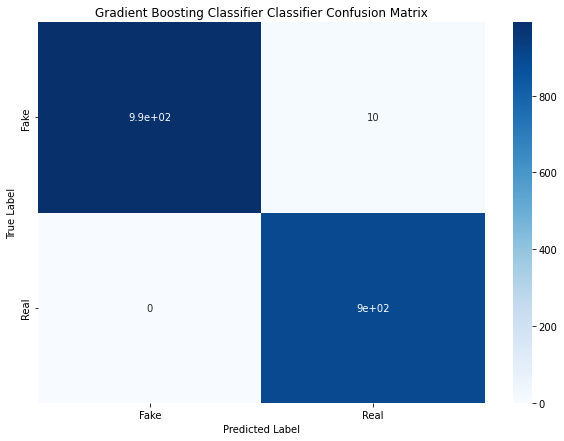

In [30]:
plot_conf_matrix(y_pred, y_test, title="Gradient Boosting Classifier Classifier")

# Model 3: Random Forest Classifier

In [31]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier()
# Fit model 
rf_model.fit(X_train, y_train)
# Predict 
y_pred = rf_model.predict(X_test)

In [32]:
params = {
    "n_estimators": [10, 50, 100, 200],
    "min_samples_leaf": [1, 2, 4],
}
gs_clf = GridSearchCV(RandomForestClassifier(), params, n_jobs=-1)
gs_clf = gs_clf.fit(X_train, y_train)
# Predict 
y_pred = gs_clf.predict(X_test)

In [33]:
print(f"Test Accuracy: {accuracy_score(y_test, y_pred)}")

Test Accuracy: 0.9942013705851345


In [34]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       991
           1       1.00      0.99      0.99       906

    accuracy                           0.99      1897
   macro avg       0.99      0.99      0.99      1897
weighted avg       0.99      0.99      0.99      1897



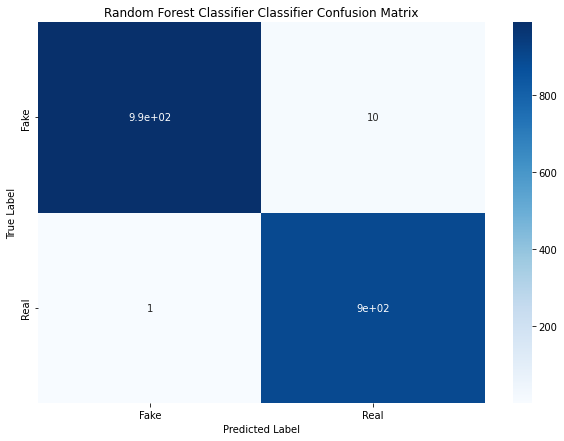

In [35]:
plot_conf_matrix(y_pred, y_test, title="Random Forest Classifier Classifier")